# ==================================================

# Task 4

In [1]:
### import os
import wer
import openfst_python as fst
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from vetrbi import MyViterbiDecoder
from utils import parse_lexicon, generate_symbol_tables
from hmm import generate_word_sequence_recognition_wfst
from hmm import generate_word_sequence_recognition_wfst_with_silance
from utils import draw
import numpy as np
import pickle


def create_wfst():
    f = generate_word_sequence_recognition_wfst(3)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f

def create_wfst_with_silance():
    f = generate_word_sequence_recognition_wfst_with_silance(3, use_unigram_probs=False)
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    return f


def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription

def memory_of_wfst(f):
    '''
    Compute a measure of the memory required for your decoder by providing counts
    of number of states and arcs in the WFST.
    '''
    all_states = []
    all_arcs = []
    for state in f.states():
        all_states.append(state)
        for arc in f.arcs(state):
            all_arcs.append(arc)
    return len(all_states), len(all_arcs)
    
def get_avg_wer(all_losses, verbose=False):
    all_wer = []
    for error_counts, word_count in all_losses:
        all_wer.append(sum(error_counts) / word_count)
    
    if verbose :
        print(f'The average WER is {np.mean(all_wer):.2%}')    
    return np.mean(all_wer)

def get_avg_effciency(efficancy_measures, verbose=False):
    decoding_time = np.mean(efficancy_measures[0])
    backtrace_time = np.mean(efficancy_measures[1])
    number_of_computions = np.mean(efficancy_measures[2])
    if verbose:
        print(f'The average decoding time is {decoding_time:.2f} seconds')
        print(f'The average backtrace time is {backtrace_time:.2f} seconds')
        print(f'The average number of computations is {number_of_computions:.2f}')
    return decoding_time, backtrace_time, number_of_computions


def decoding_loop(f, train_set=True, train_split=0.85, use_pruning=False, determinized=False, verbose=False, prune_threshold= None):
    all_losses = []
    decoding_time = []
    backtrace_time = []
    number_of_computations = []
    all_files = glob.glob('/group/teaching/asr/labs/recordings/*.wav')
    train_files = all_files[:(int(train_split*len(all_files)))]
    test_files = all_files[(int(train_split*len(all_files))):]
    
    if train_set:
        files= train_files
    else:
        files = test_files
    
    for wav_file in tqdm(files):    
        decoder  = MyViterbiDecoder(f, wav_file, verbose=verbose, use_pruning=use_pruning, determinized=determinized)
        if use_pruning and prune_threshold!=None:
            decoder.prune_threshold = prune_threshold
        decoder.decode()
        (state_path, words) = decoder.backtrace()  
        transcription = read_transcription(wav_file)
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())

        all_losses.append((error_counts, word_count))
        decoding_time.append(decoder.decode_time)
        backtrace_time.append(decoder.backtrace_time)
        number_of_computations.append(decoder.number_of_computiations)
        if verbose:
            print(f'Transcription: {transcription} || Prediction: {words} || (nsub, ndel, nin) :{error_counts}')
    
    efficancy_measures = (decoding_time, backtrace_time, number_of_computations)
    return all_losses, efficancy_measures


lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)
f = create_wfst()
f_silence = create_wfst_with_silance()
f_det = fst.determinize(f)

 85%|████████████████████████████████▏     | 269/318 [00:00<00:00, 32511.17it/s]


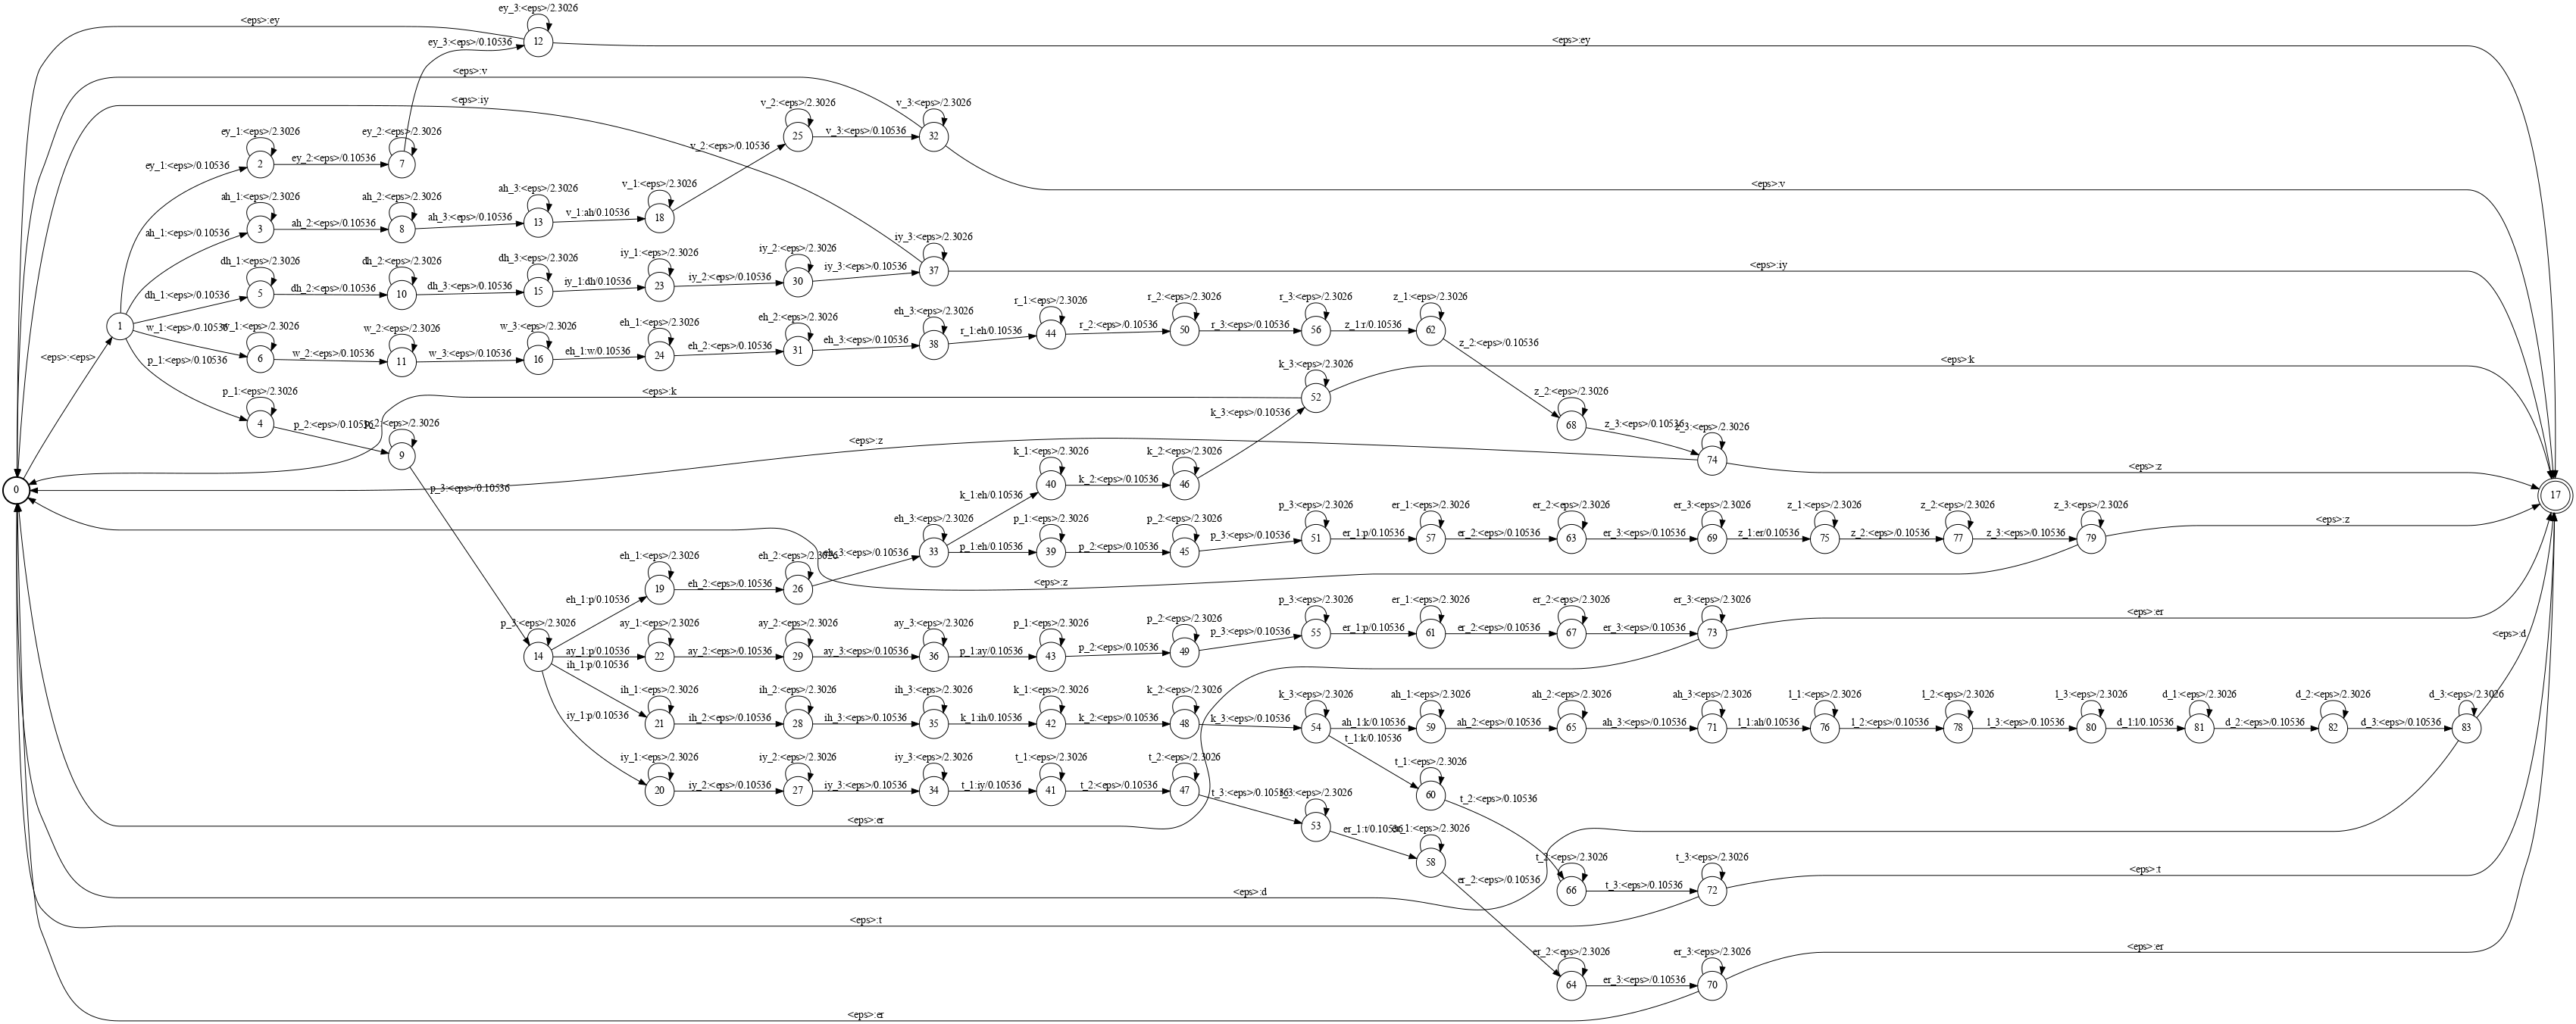

In [5]:
draw(f_det)

In [4]:
decoder.start_state

NameError: name 'decoder' is not defined

In [2]:
exp_dict= {
    'loss' : [],
    'efficancy':[],
    'acc': [],
    'm1': [],
    'm2': [],
    'm3': [],
    'all_states': [],
    'all_arcs': [],
    'det': False    
}

det = True

if det:
    wfst = f_det
else:
    wfst = f

exp_dict['det'] = det
exp_dict['all_states'], exp_dict['all_arcs'] = memory_of_wfst(wfst)

verbose = True
print(f'det = {det}')
print(f'All states: {exp_dict["all_states"]}, all arcs: {exp_dict["all_arcs"]}')
all_losses, efficancy_measures = decoding_loop(f, train_set=True, train_split=0.05, determinized=det, verbose=verbose)
avg_wer = get_avg_wer(all_losses, verbose=True)
m1,m2,m3 = get_avg_effciency(efficancy_measures, verbose=verbose)
exp_dict['loss'].append(all_losses)
exp_dict['efficancy'].append(efficancy_measures)
exp_dict['acc'].append(avg_wer)
exp_dict['m1'].append(m1)
exp_dict['m2'].append(m2)
exp_dict['m3'].append(m3)
print('\n\n\n')
file_name = f'exp_dict_baseline_det_{det}_lexical_tree.pkl'
with open(file_name, 'wb') as handler:
    pickle.dump(exp_dict, handler)
print(f'saved to {file_name}')





det = True
All states: 84, all arcs: 183


  7%|██▉                                         | 1/15 [00:03<00:47,  3.38s/it]

Decoding took 2.384068250656128 seconds
Number of computations: 71898
Phones:  ['', ' p ih k t dh iy dh iy dh iy dh iy ah v p ih k ah l d p ay p er dh iy ah v p iy t er ey p ih k t dh iy dh iy dh iy dh iy dh iy dh iy']
best_out_sequence:  <eps> p ih k t dh iy dh iy dh iy dh iy ah v p ih k ah l d p ay p er dh iy ah v p iy t er ey p ih k t dh iy dh iy dh iy dh iy dh iy dh iy
best_state_sequence:  [-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 97, 98, 99, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 5, 5, 5, 5, 6, 7, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 10, 64, 65, 66, 67, 67, 67, 68, 68, 69, 69, 69, 70, 70, 70, 70, 71, 71, 72, 72, 72, 73, 74, 75, 76, 76, 76, 77, 78, 

 13%|█████▊                                      | 2/15 [00:05<00:35,  2.74s/it]

Decoding took 1.6143853664398193 seconds
Number of computations: 48588
Phones:  ['', ' p ih k t dh iy dh iy w eh r z p iy t er p ih k t p ih k t dh iy dh iy p ih k t dh iy dh iy dh iy']
best_out_sequence:  <eps> p ih k t dh iy dh iy w eh r z p iy t er p ih k t p ih k t dh iy dh iy p ih k t dh iy dh iy dh iy
best_state_sequence:  [-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 99, 100, 101, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 104, 105, 105, 105, 105, 106, 107, 107, 108, 109, 110, 111, 112, 112, 112, 112, 112, 113, 113, 113, 114, 114, 114, 114, 114, 38, 38, 38, 39, 39, 40, 40, 40, 40, 41, 41, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,

 20%|████████▊                                   | 3/15 [00:08<00:32,  2.74s/it]

Decoding took 2.000612497329712 seconds
Number of computations: 59298
Phones:  ['', ' p ih k t dh iy dh iy dh iy dh iy p iy t er p ih k t ah v p eh k dh iy dh iy dh iy ey p ih k t dh iy dh iy dh iy dh iy']
best_out_sequence:  <eps> p ih k t dh iy dh iy dh iy dh iy p iy t er p ih k t ah v p eh k dh iy dh iy dh iy ey p ih k t dh iy dh iy dh iy dh iy
best_state_sequence:  [-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 97, 98, 99, 100, 101, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 44, 45, 45, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 47, 48, 49, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 53, 53, 53, 54, 55, 55, 56, 57, 57, 57, 58, 58, 58, 58, 59, 59, 59, 59, 59, 60, 60, 60, 60, 61, 62, 62, 62, 5, 

 27%|███████████▋                                | 4/15 [00:11<00:30,  2.75s/it]

Decoding took 2.027865171432495 seconds
Number of computations: 61188
Phones:  ['', ' p ih k t dh iy dh iy dh iy w eh r z dh iy p eh p er z p ih k t dh iy dh iy dh iy p ih k t']
best_out_sequence:  <eps> p ih k t dh iy dh iy dh iy w eh r z dh iy p eh p er z p ih k t dh iy dh iy dh iy p ih k t
best_state_sequence:  [-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 104, 105, 105, 105, 106, 106, 107, 107, 107, 108, 109, 110, 111, 112, 112, 112, 112, 112, 113, 113, 114, 114, 114, 114, 114, 114, 96, 96, 96,

 33%|██████████████▋                             | 5/15 [00:14<00:28,  2.88s/it]

Decoding took 2.249232292175293 seconds
Number of computations: 68328
Phones:  ['', ' p ih k t dh iy dh iy p ay p er p ih k t p ih k ah l d p eh p er z p ih k t p ih k t p ih k t dh iy dh iy dh iy p ih k t']
best_out_sequence:  <eps> p ih k t dh iy dh iy p ay p er p ih k t p ih k ah l d p eh p er z p ih k t p ih k t p ih k t dh iy dh iy dh iy p ih k t
best_state_sequence:  [-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 98, 98, 99, 100, 101, 83, 83, 83, 83, 83, 83, 83, 84, 84, 85, 85, 85, 85, 85, 86, 86, 86, 87, 87, 87, 88, 88, 88, 88, 88, 89, 90, 91, 92, 93, 94, 51, 52, 53, 53, 53, 54, 55, 55, 56, 57, 57, 57, 58, 58, 59, 60, 61, 62, 64, 65, 66, 67,

 40%|█████████████████▌                          | 6/15 [00:19<00:34,  3.83s/it]

Decoding took 4.154149293899536 seconds
Number of computations: 125658
Phones:  ['', ' p ih k t dh iy p ih k t p eh k dh iy p ih k t dh iy dh iy p ih k t p ih k t dh iy ey ah v ey ah v p ih k ah l d p eh k ah v p ih k ah l d ey dh iy ah v p eh p er z p ih k t dh iy dh iy']
best_out_sequence:  <eps> p ih k t dh iy p ih k t p eh k dh iy p ih k t dh iy dh iy p ih k t p ih k t dh iy ey ah v ey ah v p ih k ah l d p eh k ah v p ih k ah l d ey dh iy ah v p eh p er z p ih k t dh iy dh iy
best_state_sequence:  [-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 60, 60, 60, 61, 62, 62, 62, 62, 62, 62, 62, 12, 12, 12, 13, 14, 15, 16, 17, 18, 19, 20, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96

 47%|████████████████████▌                       | 7/15 [00:23<00:29,  3.73s/it]

Decoding took 2.5925121307373047 seconds
Number of computations: 77148
Phones:  ['', ' p ih k t dh iy dh iy dh iy p eh k w eh r z p ih k ah l d p ih k t w eh r z p ih k t p ay p er ey p ih k t p ih k t dh iy dh iy p ih k t dh iy dh iy']
best_out_sequence:  <eps> p ih k t dh iy dh iy dh iy p eh k w eh r z p ih k ah l d p ih k t w eh r z p ih k t p ay p er ey p ih k t p ih k t dh iy dh iy p ih k t dh iy dh iy
best_state_sequence:  [-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 98, 99, 100, 101, 12, 12, 13, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 17, 17, 17, 18, 18, 18, 18, 19, 19, 20, 20, 103, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 64, 65, 66, 67, 67, 67, 68, 68, 68, 68,

 53%|███████████████████████▍                    | 8/15 [00:27<00:27,  3.86s/it]

Decoding took 3.062283515930176 seconds
Number of computations: 91638
Phones:  ['', ' p ih k t dh iy dh iy dh iy dh iy dh iy dh iy dh iy dh iy dh iy w eh r z ah v p eh k ah v dh iy p ih k ah l d p ih k t w eh r z p ih k t p ay p er ey p ih k t p ih k t dh iy']
best_out_sequence:  <eps> p ih k t dh iy dh iy dh iy dh iy dh iy dh iy dh iy dh iy dh iy w eh r z ah v p eh k ah v dh iy p ih k ah l d p ih k t w eh r z p ih k t p ay p er ey p ih k t p ih k t dh iy
best_state_sequence:  [-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 97, 98, 99, 99, 99, 100, 101, 96, 97, 98, 99, 99, 100, 101, 96, 97, 98, 99, 99, 99, 99, 99, 100, 101, 96, 97, 98, 99, 100, 101, 96, 97, 98, 99, 100, 101, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 103, 103, 103, 

 60%|██████████████████████████▍                 | 9/15 [00:31<00:23,  3.94s/it]

Decoding took 3.0632364749908447 seconds
Number of computations: 91638
Phones:  ['', ' p ih k t dh iy p iy t er p ih k t ah v p eh k ah v p ih k ah l d p eh p er z p ih k t dh iy dh iy p ih k t']
best_out_sequence:  <eps> p ih k t dh iy p iy t er p ih k t ah v p eh k ah v p ih k ah l d p eh p er z p ih k t dh iy dh iy p ih k t
best_state_sequence:  [-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 44, 45, 46, 46, 46, 46, 47, 47, 48, 49, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 53, 53, 53, 53, 53, 53, 54, 55, 55, 56, 57, 57, 57, 57, 57, 58, 58

 67%|████████████████████████████▋              | 10/15 [00:35<00:19,  3.88s/it]

Decoding took 2.7626123428344727 seconds
Number of computations: 82608
Phones:  ['', ' p ih k t dh iy w eh r z ah v p eh k ah v p ih k ah l d p eh k w eh r z ah v ah v ah v dh iy dh iy dh iy dh iy dh iy dh iy']
best_out_sequence:  <eps> p ih k t dh iy w eh r z ah v p eh k ah v p ih k ah l d p eh k w eh r z ah v ah v ah v dh iy dh iy dh iy dh iy dh iy dh iy
best_state_sequence:  [-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 104, 104, 105, 105, 105, 105, 106, 107, 108, 109, 110, 111, 112, 112, 112, 112, 112, 112, 112, 112, 112, 113, 113, 113, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 5, 6, 7, 8, 8, 9, 10, 10, 10, 12, 12, 13, 13, 14, 14, 14, 14, 14, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 18, 1

 73%|███████████████████████████████▌           | 11/15 [00:39<00:15,  3.80s/it]

Decoding took 2.643301010131836 seconds
Number of computations: 79038
Phones:  ['', ' p ih k t p ih k t dh iy dh iy dh iy p ih k ah l d p eh k w eh r z p eh k p iy t er p ay p er ey p ih k t p ih k t dh iy p ih k t dh iy dh iy']
best_out_sequence:  <eps> p ih k t p ih k t dh iy dh iy dh iy p ih k ah l d p eh k w eh r z p eh k p iy t er p ay p er ey p ih k t p ih k t dh iy p ih k t dh iy dh iy
best_state_sequence:  [-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 51, 52, 53, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 55, 56, 57, 58, 59, 60, 61, 62, 96, 97, 98, 99, 100, 101, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 64, 65, 66, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 70, 70, 70, 71, 71, 71, 71, 72, 72, 73, 74, 75, 76, 76, 76, 76, 76, 77, 78, 79, 79, 79, 79, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 12, 13, 14, 14, 15, 15,

 80%|██████████████████████████████████▍        | 12/15 [00:45<00:13,  4.44s/it]

Decoding took 4.3295769691467285 seconds
Number of computations: 129228
Phones:  ['', ' p eh k dh iy dh iy p iy t er p ay p er p ih k t ey ey ah v p eh k ah v p ih k ah l d p eh p er z w eh r z dh iy p eh k p ih k t p ih k t dh iy p eh p er z p iy t er p ay p er p ih k t p ih k t p ih k t dh iy dh iy']
best_out_sequence:  <eps> p eh k dh iy dh iy p iy t er p ay p er p ih k t ey ey ah v p eh k ah v p ih k ah l d p eh p er z w eh r z dh iy p eh k p ih k t p ih k t dh iy p eh p er z p iy t er p ay p er p ih k t p ih k t p ih k t dh iy dh iy
best_state_sequence:  [-1, 12, 13, 14, 15, 16, 17, 18, 19, 20, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 38, 39, 40, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43, 44, 45, 46, 46, 46, 46, 46, 47, 47, 48, 48, 49, 49, 49, 49, 83, 83, 84, 85, 86, 86, 86, 86, 86, 86, 86, 86, 87, 87, 88, 88, 88, 88, 88, 88, 8

 87%|█████████████████████████████████████▎     | 13/15 [00:47<00:07,  3.96s/it]

Decoding took 2.0550577640533447 seconds
Number of computations: 62868
Phones:  ['', ' p ih k t dh iy dh iy dh iy dh iy p iy t er p ay p er ah v p ih k t p eh k w eh r z p ih k t p ih k t']
best_out_sequence:  <eps> p ih k t dh iy dh iy dh iy dh iy p iy t er p ay p er ah v p ih k t p eh k w eh r z p ih k t p ih k t
best_state_sequence:  [-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 38, 39, 40, 41, 41, 41, 41, 41, 41, 42, 42, 42, 42, 42, 42, 43, 43, 44, 45, 46, 46, 46, 46, 46, 46, 46, 47, 48, 49, 83, 83, 83, 83, 83, 83, 83, 84, 85, 86, 86, 86, 86, 86, 86, 86, 87, 87, 

 93%|████████████████████████████████████████▏  | 14/15 [00:52<00:04,  4.15s/it]

Decoding took 3.342162609100342 seconds
Number of computations: 102348
Phones:  ['', ' p ih k t dh iy dh iy dh iy p ih k t ah v p ih k ah l d p eh p er z w eh r z dh iy p eh p er z p ih k t p ih k t p ih k ah l d p ih k t dh iy dh iy']
best_out_sequence:  <eps> p ih k t dh iy dh iy dh iy p ih k t ah v p ih k ah l d p eh p er z w eh r z dh iy p eh p er z p ih k t p ih k t p ih k ah l d p ih k t dh iy dh iy
best_state_sequence:  [-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 59, 60, 61, 62, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 51, 52, 53, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 56, 57, 58, 59, 60, 61, 62, 62, 62, 62, 62, 5, 6, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 64, 64, 64, 64, 65, 65, 65, 66, 66, 66, 67, 68, 68, 69, 70, 70, 71, 71, 71, 72, 72, 72, 72, 73, 74, 75, 76, 76, 76, 77, 77, 78, 78, 79, 80, 81

100%|███████████████████████████████████████████| 15/15 [00:55<00:00,  3.69s/it]

Decoding took 2.081432580947876 seconds
Number of computations: 62868
Phones:  ['', ' p ih k t dh iy dh iy dh iy p ih k t p ih k t dh iy ah v p ih k ah l d p ih k t dh iy p eh k w eh r z p ih k t dh iy']
best_out_sequence:  <eps> p ih k t dh iy dh iy dh iy p ih k t p ih k t dh iy ah v p ih k ah l d p ih k t dh iy p eh k w eh r z p ih k t dh iy
best_state_sequence:  [-1, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 96, 96, 96, 96, 96, 96, 97, 98, 99, 100, 101, 51, 52, 53, 54, 54, 54, 54, 54, 54, 54, 55, 56, 57, 57, 58, 59, 60, 61, 62, 51, 52, 53, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 56, 57, 58, 59, 60, 61, 62, 62, 96, 97, 98, 99, 100, 100, 101, 5, 6, 7, 8, 8, 8, 8, 8, 8, 9, 10, 10, 10, 10, 10, 64, 64, 64, 64, 65, 65, 65, 66, 66, 67, 67, 68, 68, 69, 70, 70, 70, 70, 71, 71, 72, 72, 72, 72, 73, 74, 75, 76, 76, 76, 77, 78, 78, 79, 79, 79, 80, 81, 

# ======================================================